# Installation

In [ ]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip install ipympl

# Imports

In [3]:
import tensorflow as tf
import cv2
# from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import keras
import pandas as pd

2024-06-15 15:04:55.561659: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 15:04:55.561823: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 15:04:55.768819: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data

## Initializing Environment in Kaggle

In [5]:
dataset_dir = '/kaggle/working'

In [6]:
import os
import json

from kaggle_secrets import UserSecretsClient
secrets = UserSecretsClient()

os.environ['KAGGLE_USERNAME'] = secrets.get_secret("KAGGLE_USERNAME")
os.environ['KAGGLE_KEY'] = secrets.get_secret("KAGGLE_KEY")

In [7]:
# meta = dict(
#     id="ishansrivastava1308/Cloud-Images-19510",
#     title="Cloud images Dataset",
#     isPrivate=True,
#     licenses=[dict(name="other")]
# )

# with open(os.path.join('dataset-metadata.json'), 'w') as f:
#     json.dump(meta, f)


In [8]:
# !kaggle datasets init

In [9]:
# !kaggle datasets create -p {dataset_dir} --dir-mode zip

## Initializing Environment in Google Colab

In [10]:
import os
import json

from google.colab import userdata

os.environ['KAGGLE_USERNAME'] = userdata.get("KAGGLE_USERNAME")
os.environ['KAGGLE_KEY'] = userdata.get("KAGGLE_KEY")

ModuleNotFoundError: No module named 'google.colab'

## Downloading Data in google colab

In [ ]:
!kaggle datasets download ishansrivastava1308/cloud-images-19510 -p /content/kaggle/input --force
!unzip /content/kaggle/input/cloud-images-19510.zip -d /content/kaggle/input/cloud-images-19510 && rm /content/kaggle/input/cloud-images-19510.zip


In [ ]:
rm -r kaggle/input/

## Undistorting Images

In [11]:
PWD = os.getcwd()
print(PWD)

/


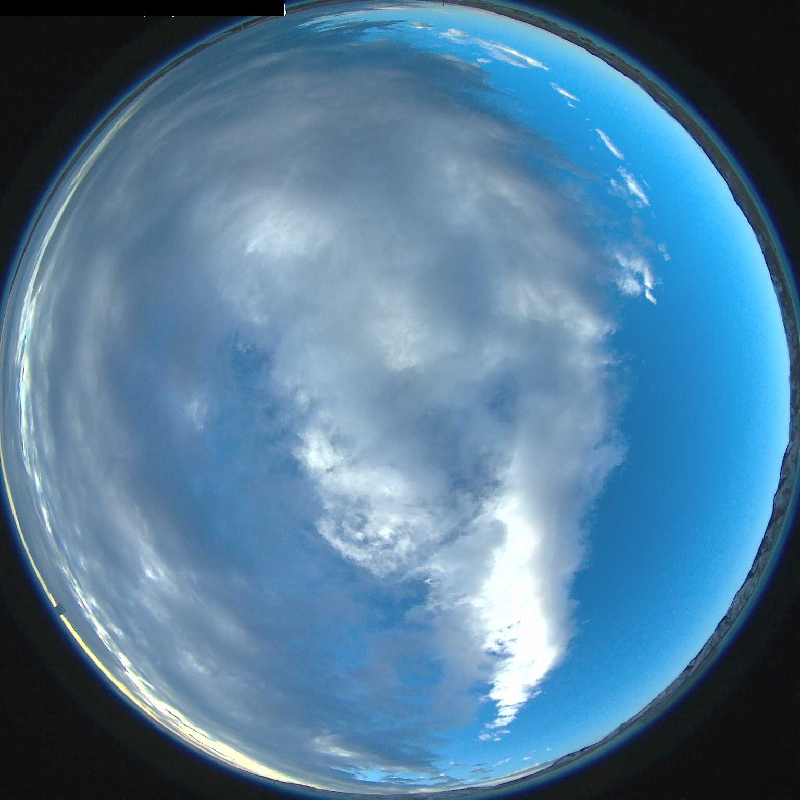

In [12]:
img = tf.keras.utils.load_img(os.path.join(PWD,'kaggle/input/cloud-images-19510/0101/0101075000.jpg'), target_size = (800,800))
img

In [13]:
dist = 0.4; f = 400;
dim = 2048
DIM=(dim, dim)
K=np.array([
    [f, 0.0, 1536/2],
    [0.0, f, 1536/2],
    [0.0, 0.0, 1.0]])
D=np.array([[dist],[dist],[dist],[dist]])


def undistort(img_path = None,zoom_out_factor = 1, balance=0.0, dim2=None, dim3=None,*args, **kwargs):
    img = cv2.imread(img_path)

    dim1 = img.shape[:2][::-1]  #dim1 is the dimension of input image to un-distort
    assert dim1[0]/dim1[1] == DIM[0]/DIM[1], "Image to undistort needs to have same aspect ratio as the ones used in calibration"
    if not dim2:
        dim2 = dim1
    if not dim3:
        dim3 = dim1
    scaled_K = K.copy()
#     scaled_K[0][0] /= zoom_out_factor
#     scaled_K[1][1] /= zoom_out_factor
#     scaled_K[2][2] = 1.0  # Except that K[2][2] is always 1.0
    # This is how scaled_K, dim2 and balance are used to determine the final K used to un-distort image. OpenCV document failed to make this clear!
#     new_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(scaled_K, D, dim2, , balance=balance)
    new_K = K.copy()
    new_K[0][0] /= zoom_out_factor
    new_K[1][1] /= zoom_out_factor
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(scaled_K, D, np.eye(3), new_K, dim3, cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_AREA, borderMode=cv2.BORDER_CONSTANT)
    undistorted_img = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)
    undistorted_img = cv2.resize(undistorted_img, (1000,1000))
    return undistorted_img








In [31]:
def undistort_func(img_path, zoom_out_factor, balance, f, dist):
    dim = 2048
    DIM=(dim, dim)
    img = cv2.imread(img_path)
    
    K=np.array([
        [f, 0.0, 1536/2],
        [0.0, f, 1536/2],
        [0.0, 0.0, 1.0]])
    D=np.array([[dist],[dist],[dist],[dist]])


    dim1 = img.shape[:2][::-1]  #dim1 is the dimension of input image to un-distort
    new_K = np.array([
        [f / zoom_out_factor, 0.0, 1536/2],
        [0.0, f /zoom_out_factor, 1536/2],
        [0.0, 0.0, 1.0]])
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), new_K, dim1, cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_AREA, borderMode=cv2.BORDER_CONSTANT)
    undistorted_img = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)
    undistorted_img = cv2.resize(undistorted_img, (1000,1000))
    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.imshow(undistorted_img)

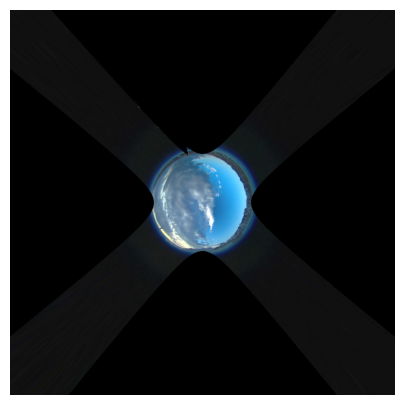

In [32]:
undistort_func(os.path.join(PWD,'kaggle/input/cloud-images-19510/0101/0101075000.jpg'),16,1,250,0.025)

In [33]:

import IPython
from IPython.display import display
from ipywidgets import interact, IntSlider, fixed, FloatSlider, IntRangeSlider

img = cv2.imread(os.path.join(PWD,'kaggle/input/cloud-images-19510/0101/0101075000.jpg'))

@interact(
    img=fixed(value = img), 
    dist = FloatSlider(description = 'Dist'.ljust(15) + ':',  min = 0.,max = 1.,step = 0.001, readout_format = '0.3f'), 
    f = (1,1000,1), 
    zoom_out_factor = (1,200,1),
    balance = (0.,1.,0.1)
)
def undistorted_wrap(img,dist = 0.025, f = 400 ,zoom_out_factor = 2, balance=1.0,*args, **kwargs):
    dim = 2048
    DIM=(dim, dim)
#     img = cv2.imread(img_path)
    
    K=np.array([
        [f, 0.0, 1536/2],
        [0.0, f, 1536/2],
        [0.0, 0.0, 1.0]])
    D=np.array([[dist],[dist],[dist],[dist]])


    dim1 = img.shape[:2][::-1]  #dim1 is the dimension of input image to un-distort
    new_K = np.array([
        [f / zoom_out_factor, 0.0, 1536/2],
        [0.0, f /zoom_out_factor, 1536/2],
        [0.0, 0.0, 1.0]])
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), new_K, dim1, cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_AREA, borderMode=cv2.BORDER_CONSTANT)
    undistorted_img = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)
    undistorted_img = cv2.resize(undistorted_img, (1000,1000))
    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.imshow(undistorted_img)


interactive(children=(FloatSlider(value=0.0, description='Dist           :', max=1.0, readout_format='0.3f', s…

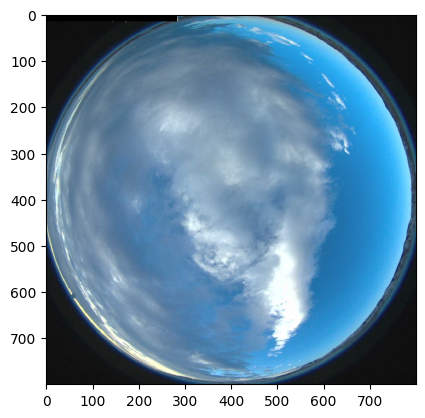

In [55]:
plt.imshow(img)

In [41]:

# img = cv2.imread(os.path.join(PWD,'/kaggle/input/cloud-images-19510/0101/0101100000.jpg'))
image = cv2.imread(os.path.join(PWD,'kaggle/input/cloud-images-19510/0101/0101075000.jpg'))

import IPython
from IPython.display import display
from ipywidgets import interact, IntSlider, fixed, FloatSlider, IntRangeSlider, interactive,interactive_output, HBox, VBox, Box, Layout

def undistorted_wrap_with_coeffs(img, f = 400 ,zoom_out_factor = 2, balance=1.0, k1 = 0.025, k2 = 0.025, k3 =0.025, k4 = 0.025, figsize = 1):
    dim = 2048
    DIM=(dim, dim)
#     img = cv2.imread(img_path)
    K=np.array([
        [f, 0.0, 1536/2],
        [0.0, f, 1536/2],
        [0.0, 0.0, 1.0]])
    D=np.array([[k1],[k2],[k3],[k4]])

    dim1 = img.shape[:2][::-1]  #dim1 is the dimension of input image to un-distort
    new_K = np.array([
        [f / zoom_out_factor, 0.0, 1536/2],
        [0.0, f /zoom_out_factor, 1536/2],
        [0.0, 0.0, 1.0]])
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), new_K, dim1, cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_AREA, borderMode=cv2.BORDER_CONSTANT)
    undistorted_img = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)
    undistorted_img = cv2.resize(undistorted_img, (1000,1000))
    plt.figure(figsize=(figsize,figsize))
    plt.axis('off')
    plt.imshow(undistorted_img)
    
    
img                       = fixed(description = 'img'.ljust(15) + ':', value =  image)
f                         = IntSlider(description = 'f'.ljust(15) + ':',  min = 1,max = 1000, step = 1, value = 250)
zoom_out_factor           = IntSlider(description = 'zoom_out_factor'.ljust(15) + ':',  min = 1,max = 200,step = 1, value = 16)
balance                   = FloatSlider(description = 'balance'.ljust(15) + ':',  min = 0.,max = 1.,step = 0.1,value = 1)
k1                        = FloatSlider(description = 'k1'.ljust(15) + ':',  min = 0.,max = 1.,step = 0.001, value = 0.025, readout_format = '0.3f')
k2                        = FloatSlider(description = 'k2'.ljust(15) + ':',  min = 0.,max = 1.,step = 0.001, value = 0.025,readout_format = '0.3f')
k3                        = FloatSlider(description = 'k3'.ljust(15) + ':',  min = 0.,max = 1.,step = 0.001, value = 0.025,readout_format = '0.3f')
k4                        = FloatSlider(description = 'k4'.ljust(15) + ':',  min = 0.,max = 1.,step = 0.001, value = 0.025,readout_format = '0.3f')
figsize                   = IntSlider(description = 'figsize'.ljust(15) + ':',  min = 3, max = 15, step = 1, value = 9)
    
    
args = {
    'img' : img , 
    'f'  : f , 
    'zoom_out_factor'  : zoom_out_factor ,
    'balance'  : balance , 
    'k1'  : k1 ,
    'k2'  : k2 ,
    'k3'  : k3 ,
    'k4'  : k4 ,
    'figsize' : figsize ,
}

distort_widget = interactive_output(
    undistorted_wrap_with_coeffs,
    args
)



In [42]:
sliders = list(args.values())

In [43]:
HBox([VBox(children = sliders[1:]), distort_widget], layout = Layout(flex = 'flex-row'))

In [60]:
display(distort_widget)

Output()

In [62]:
distort_widget

Output()

In [ ]:
%matplotlib inline

In [ ]:
import IPython
from IPython.display import display
from ipywidgets import interact, IntSlider, fixed, FloatSlider, IntRangeSlider
balance = FloatSlider(min=0, max=1, value=1, description='Balance:')
display(interact(
    undistorted_widget_wrap,
    img = fixed('/kaggle/input/cloud-images-19510/0105/0105120000.jpg'),
    dist = FloatSlider(min = 0, max = 1, step = 0.00001, value = 0.01),
    f = IntSlider(min = 1, max = 1000, step = 1, value = 400),
    zoom_out_factor=FloatSlider(min=0, max=20, step=0.01, value=5),
    balance = balance,

))

#

In [ ]:
!jupyter nbextension enable --py --sys-prefix widgetsnbextension

In [ ]:
%matplotlib notebook
import ipywidgets as widgets

# For explicitly displaying widgets
from IPython.display import display

# Just need these for the demo purposes here
from datetime import datetime
import matplotlib.pyplot as plt
demo_IntSlider_1 = widgets.IntSlider(
    min=1,                      # The minimum value
    max=100,                    # The maximum value
    description='Int Slider 1', # Label
    value=53,                   # Default value
)

# Display the widget
display(demo_IntSlider_1)

In [ ]:
u_img = undistort('/kaggle/input/cloud-images-19510/0105/0105112000.jpg',zoom_out_factor = 100,balance = 1)
tf.keras.utils.array_to_img(u_img)

In [ ]:

fig,ax = plt.subplots(nrows = 3, ncols = 3)
axes = ax.flatten()
for a in axes:
    a.imshow()

In [ ]:
tf.keras.utils.array_to_img(map1)

In [ ]:
tf.keras.utils.array_to_img(undistort('/kaggle/input/cloud-images-19510/0101/0101075000.jpg',balance = 1), )

In [ ]:
plt.imshow(img)

In [ ]:
img

# Data Preprocessing

## Creating Tensorflow Datsets

In [ ]:
base_path = '/kaggle/input/cloud-images-19510'

In [ ]:
image_paths = [sorted([os.path.join(root,file) for file in files if file.endswith('.jpg')]) for root,dirs,files in os.walk(base_path) if len(dirs) == 0]

In [ ]:
flattened_image_paths = sorted([os.path.join(root,file) for root,dirs,files in os.walk(base_path) for file in files if not file.endswith('.csv')])

In [ ]:
def undistort_from_array(img, dim2 = None, dim3 = None, balance = 0):
    dim1 = img.shape[:2][::-1]  #dim1 is the dimension of input image to un-distort
    assert dim1[0]/dim1[1] == DIM[0]/DIM[1], "Image to undistort needs to have same aspect ratio as the ones used in calibration"
    if not dim2:
        dim2 = dim1
    if not dim3:
        dim3 = dim1
    scaled_K = K * dim1[0] / DIM[0]  # The values of K is to scale with image dimension.
    scaled_K[2][2] = 1.0  # Except that K[2][2] is always 1.0
    # This is how scaled_K, dim2 and balance are used to determine the final K used to un-distort image. OpenCV document failed to make this clear!
    new_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(scaled_K, D, dim2, np.eye(3), balance=balance)
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(scaled_K, D, np.eye(3), new_K, dim3, cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    undistorted_img = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)
    undistorted_img = cv2.resize(undistorted_img, (1000,1000))
    return undistorted_img


In [ ]:
import tensorflow as tf

class Preprocessor:
    def __init__(
            self,
            filepaths : list[str]
    ):
        self.filepaths = filepaths
        self.dataset = None

    def get_dataset_iterator(self,func):
        if self.dataset:
            return self.dataset
        self.dataset = tf.data.Dataset.from_tensor_slices(self.filepaths)
        self.dataset = self.dataset.map(func, num_parallel_calls=tf.data.AUTOTUNE)
        # self.dataset = self.dataset.cache()
        # self.dataset = self.dataset.shuffle(buffer_size=1000)
        # self.dataset = self.dataset.batch(32)
        # self.dataset = self.dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
        return self.dataset
@tf.function
def load_preprocess_y(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.resize(image, [128, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image

@tf.function
def get_image_from_path(file_path):
    return image

@tf.py_function(Tout=tf.float64)
def get_undistorted_img(file_path):
    path_str = file_path.numpy().decode('utf-8')
    image = undistort(path_str,zoom_out_factor = 10,balance = 1)
    return tf.convert_to_tensor(image,dtype = tf.float64)

In [ ]:
train_ds_x = Preprocessor(flattened_image_paths).get_dataset_iterator(get_undistorted_img)
# train_ds_x.map(get_undistorted_img)

In [ ]:
image_iter = train_ds_x.as_numpy_iterator()

In [ ]:
def show_grid_samples(ncols = 3,nrows = 3,scale = 1,**kwargs):
    figsize = (ncols * scale, nrows * scale)
    plt.tight_layout()
    fig,ax = plt.subplots(ncols = ncols, nrows = nrows, figsize = figsize)
    axes = ax.flatten()
    for a in axes:
        a.imshow(image_iter.next()/255, interpolation = 'nearest')
        a.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)

    plt.show()

In [ ]:
%matplotlib notebook

In [ ]:
show_grid_samples(ncols = 3,nrows = 10,scale = 5)

# Tabular Data

In [5]:
PWD =  os.getcwd()
print(PWD)

/


In [6]:
df = pd.read_csv(os.path.join(PWD,'kaggle/input/cloud-images-19510/train.csv' ))

/tmp/ipykernel_303/18740764.py:1: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(PWD,'kaggle/input/cloud-images-19510/train.csv' ))


In [33]:
df.describe()

,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Azimuth Angle [degrees],Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],Station Pressure [mBar],Precipitation (Accumulated) [mm],Snow Depth [cm],Moisture,Albedo (CMP11)
count,482400.000000,482400.000000,482400.000000,482400.000000,482400.000000,482400.000000,482400.000000,480931.000000,482400.000000,482400.000000,482400.000000,482400.000000,482400.000000,482400.000000,482400.000000
mean,203.417447,241.620827,180.002353,12.467373,5.067534,-2.698022,40.327665,23.611655,2.830681,168.190142,817.087196,0.374163,-2.826314,0.061655,0.129371
std,295.831990,369.333659,101.616425,10.578051,6.865294,7.315305,24.050161,34.740024,2.020588,116.355121,5.136720,1.928488,188.916827,0.237741,0.180258
min,-4.764200,-12.403300,0.000120,-16.690000,-17.351000,-24.830000,4.210000,0.000000,0.000000,0.000000,794.918000,0.000000,-7999.000000,0.000000,0.000000
25%,-1.081940,-0.197820,88.578010,4.170000,-0.261000,-8.109000,21.980000,0.000000,1.450000,44.580000,813.989000,0.000000,0.082000,0.000000,0.000000
50%,7.653785,0.266632,179.992330,13.020000,5.363000,-3.119000,33.630000,0.000000,2.450000,177.300000,817.553000,0.000000,0.656000,0.000000,0.000000
75%,351.550500,537.677250,271.428125,20.770000,11.096000,2.668000,53.010000,37.000000,3.700000,282.200000,820.553000,0.000000,1.032000,0.000000,0.201800
max,1428.650000,1069.200000,359.998560,36.320000,19.416000,17.418000,100.100000,100.000000,23.450000,360.000000,847.963000,28.190000,28.430000,1.000000,2.000000


In [16]:
df.columns

Index(['DATE (MM/DD)', 'MST', 'Global CMP22 (vent/cor) [W/m^2]',
       'Direct sNIP [W/m^2]', 'Azimuth Angle [degrees]',
       'Tower Dry Bulb Temp [deg C]', 'Tower Wet Bulb Temp [deg C]',
       'Tower Dew Point Temp [deg C]', 'Tower RH [%]', 'Total Cloud Cover [%]',
       'Peak Wind Speed @ 6ft [m/s]', 'Avg Wind Direction @ 6ft [deg from N]',
       'Station Pressure [mBar]', 'Precipitation (Accumulated) [mm]',
       'Snow Depth [cm]', 'Moisture', 'Albedo (CMP11)'],
      dtype='object')

In [4]:
df.loc[(df['MST'] >= '07:40') & (df['DATE (MM/DD)'] == '01-Jan') ][0:50]

NameError: name 'df' is not defined

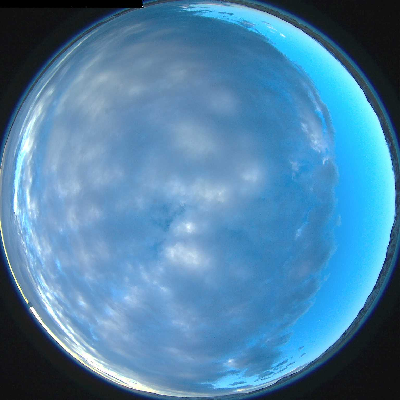

In [ ]:
tf.keras.utils.load_img('/kaggle/input/cloud-images-19510/0101/0101074000.jpg',target_size = (400,400))

In [29]:
df.loc[(df['MST'] == '07:40') & (df['DATE (MM/DD)'] == '01-Jan') ]

,DATE (MM/DD),MST,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Azimuth Angle [degrees],Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],Station Pressure [mBar],Precipitation (Accumulated) [mm],Snow Depth [cm],Moisture,Albedo (CMP11)
460,01-Jan,07:40,8.53993,1.0781,122.69154,7.202,1.503,-5.597,37.54,0.0,2.2,195.9,802.352,0.0,0.07,0.0,0.1883
